In [1]:
# %matplotlib notebook

import os
import sys
import time

import numpy as np
import pandas as pd
from numpy import Infinity

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from python.models import TCN_Davies
from python.utils import *

In [2]:
print('Torch version: {}'.format(torch.__version__))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device: %s' % (device))

Torch version: 1.3.1
Device: cpu


In [3]:
data = pd.read_csv('../data/data.csv', index_col=0)

nhid = 16
levels = 10
kernel_size = 5
dropout = 0.1

model = TCN_Davies(nhid, levels, kernel_size, dropout)
model = nn.DataParallel(model)
model.load_state_dict(torch.load('../models/TCN_Davies_1202_0.17.pt', map_location=device))
model.eval();

## State space

In [4]:
# State space

fps = 100

min_bpm = 56
max_bpm = 215

min_interval = int(60. * fps / max_bpm) #  27 frames
max_interval = int(60. * fps / min_bpm) # 107 frames

intervals = np.arange(min_interval, max_interval + 1)

num_intervals = False

if num_intervals:
    num_log_intervals = num_intervals
    intervals = []
    while len(intervals) < num_intervals:
        intervals = np.logspace(np.log2(min_interval),
                                np.log2(max_interval),
                                num_log_intervals, base=2)
        # quantize to integer intervals
        intervals = np.unique(np.round(intervals))
        num_log_intervals += 1
        
num_states = int(np.sum(intervals))
num_intervals = len(intervals)

first_states = np.cumsum(np.r_[0, intervals[:-1]])
last_states = np.cumsum(intervals) - 1

# define the positions and intervals of the states
state_positions = np.empty(num_states)
state_intervals = np.empty(num_states, dtype=np.int)

idx = 0
for i in intervals:
    state_positions[idx: idx + i] = np.linspace(0, 1, i, endpoint=False)
    state_intervals[idx: idx + i] = i
    idx += i

In [5]:
num_states

5427

## Transition model

In [6]:
# Transition model

def exponential_transition(from_intervals, to_intervals, transition_lambda):
    
    ratio = to_intervals / from_intervals[:, np.newaxis]
    prob = np.exp(-transition_lambda * abs(ratio - 1.))
    
    # set values below threshold to 0
    prob[prob <= np.spacing(1)] = 0
    
    # normalize the emission probabilities
    prob /= np.sum(prob, axis=1)[:, np.newaxis]
    
    return prob


def make_sparse(states, prev_states, probabilities):
    # check for a proper probability distribution, i.e. the emission
    # probabilities of each prev_state must sum to 1
    
    if not np.allclose(np.bincount(prev_states, weights=probabilities), 1):
        raise ValueError('Not a probability distribution.')
        
    num_states = max(prev_states) + 1
    
    transitions = csr_matrix((probabilities, (states, prev_states)), 
                             shape=(num_states, num_states))
    
    # convert to correct types
    states = transitions.indices.astype(np.uint32)
    pointers = transitions.indptr.astype(np.uint32)
    probabilities = transitions.data.astype(dtype=np.float)
    # return them
    return states, pointers, probabilities

transition_lambda = 100.0

states = np.arange(num_states, dtype=np.uint32)

# The probabiity of advancing to the next state is 1 
# except the transition from the last_state in a beat 
states = np.setdiff1d(states, first_states)
prev_states = states - 1
probabilities = np.ones_like(states, dtype=np.float)

# tempo transitions occur at the boundary between beats
from_states = last_states
to_states = first_states

from_int = state_intervals[from_states]
to_int = state_intervals[to_states]

prob = exponential_transition(from_int, to_int, transition_lambda)

# use only the states with transitions to/from != 0
from_prob, to_prob = np.nonzero(prob)

states = np.hstack((states, to_states[to_prob]))

prev_states = np.hstack((prev_states, from_states[from_prob]))
probabilities = np.hstack((probabilities, prob[prob != 0]))

tm_indices, tm_pointers, tm_probabilities = make_sparse(states, prev_states, probabilities)

tm_probabilities = np.log(tm_probabilities)

transition_model = (tm_indices, tm_pointers, tm_probabilities, num_states)

## Example processing

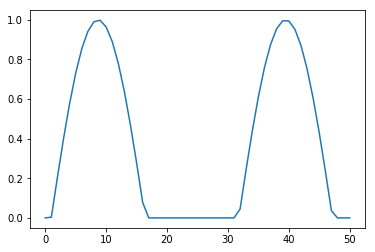

In [60]:
observations = np.sin(np.linspace(-0.2, 10, 51)).clip(0.0, 1.0)

plt.figure(0)
plt.plot(observations);

## Cut observations

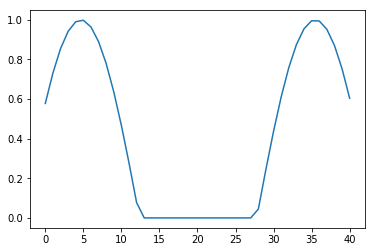

In [61]:
beats = []
correct = True
threshold = 0.5;


first = 0
# use only the activations > threshold
if threshold:
    idx = np.nonzero(observations >= threshold)[0]
    if idx.any():
        first = max(first, np.min(idx))
        last = min(len(observations), np.max(idx) + 1)
    else:
        last = first
    observations = observations[first:last]    
    
plt.figure(1)
plt.plot(observations);

## Observation model

In [62]:
# Observation model

observation_lambda = 16

om_pointers = np.zeros(num_states, dtype=np.uint32)

# unless they are in the beat range of the state space
border = 1. / observation_lambda
    
om_pointers[state_positions < border] = 1

om_densities = np.empty((len(observations), 2), dtype=np.float)

om_densities[:, 0] = np.log((1. - observations) /
                             (observation_lambda - 1))
om_densities[:, 1] = np.log(observations)

observation_model = (om_pointers, om_densities)

/Users/juliusrichter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


## Initial distribution

In [51]:
init_distribution = np.ones(num_states, dtype=np.float) / num_states

## Viterbi algorithm (python)

In [75]:
def viterbi(observations, transition_model, observation_model, init_distribution):
    
    tm_indices, tm_pointers, tm_probabilities, num_states = transition_model
    om_pointers, om_densities = observation_model
    
    num_frames = len(observations)
    
    bt_pointers = np.empty((num_frames, num_states), dtype=np.uint32)
    
    path = np.empty(num_frames, dtype=np.uint32)
    
    current_viterbi = np.empty(num_states, dtype=np.float)
    previous_viterbi = np.log(init_distribution)
            
    for frame in range(num_frames):
        print("Progress Frame {:d} of {:d}".format(frame+1, num_frames), end="\r")
        
        for state in range(num_states):
            current_viterbi[state] = -Infinity
            density = om_densities[frame, om_pointers[state]]
           
            for pointer in range(tm_pointers[state], tm_pointers[state + 1]):
                prev_state = tm_indices[pointer]
                transition_prob = previous_viterbi[prev_state] + tm_probabilities[pointer] + density
                
                if transition_prob > current_viterbi[state]:
                    # update the transition probability
                    current_viterbi[state] = transition_prob
                    # update the back tracking pointers
                    bt_pointers[frame, state] = prev_state
        
        previous_viterbi = current_viterbi
    
    state = current_viterbi.argmax()
    
    for frame in range(num_frames -1, -1, -1):
        path[frame] = state
        state = bt_pointers[frame, state]
   
    return path

In [76]:
start = time.time()
path = viterbi(observations, transition_model, observation_model, init_distribution)
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))

Progress Frame 41 of 41
Elapsed time: 0 min and 0 s


In [92]:
path

array([311, 312, 313, 314, 279, 280, 281, 282, 283, 284, 285, 286, 287,
       288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314,   0], dtype=uint32)

In [96]:
beats = np.empty(0, dtype=np.int)

if correct:
    # for each detection determine the "beat range", i.e. states where
    # the pointers of the observation model are 1
    beat_range = om_pointers[path]
    # get all change points between True and False
    idx = np.nonzero(np.diff(beat_range))[0] + 1
    # if the first frame is in the beat range, add a change at frame 0
    if beat_range[0]:
        idx = np.r_[0, idx]
    # if the last frame is in the beat range, append the length of the
    # array
    if beat_range[-1]:
        idx = np.r_[idx, beat_range.size]
    # iterate over all regions
    if idx.any():
        for left, right in idx.reshape((-1, 2)):
            left = np.maximum(0,left - (right - left))
            
            # pick the frame with the highest activations value
            peak = np.argmax(observations[left:right]) + left
            beats = np.hstack((beats, peak))
else:
    # just take the frames with the smallest beat state values
    from scipy.signal import argrelmin
    beats = argrelmin(state_positions[path], mode='wrap')[0]
    # recheck if they are within the "beat range", i.e. the pointers
    # of the observation model for that state must be 1
    # Note: interpolation and alignment of the beats to be at state 0
    #       does not improve results over this simple method
    beats = beats[pointers_om[path[beats]] == 1]
# convert the detected beats to seconds and return them

beats = (beats) 

In [103]:
path

array([311, 312, 313, 314, 279, 280, 281, 282, 283, 284, 285, 286, 287,
       288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300,
       301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313,
       314,   0], dtype=uint32)

In [100]:
beats

array([ 5, 39])

In [87]:
first

4

## Viterbi algorithm (cython)

In [67]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [68]:
%%cython

cimport numpy as np
import numpy as np

import warnings

cimport cython

from numpy.math cimport INFINITY

ctypedef np.uint32_t uint32_t

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
def viterbi_c(observations, transition_model, observation_model, initial_distribution):
    
    _tm_indices, _tm_pointers, _tm_probabilities, _num_states = transition_model
    _om_pointers, _om_densities = observation_model
    
    cdef uint32_t [::1] tm_states = _tm_indices
    cdef uint32_t [::1] tm_pointers = _tm_pointers
    cdef double [::1] tm_probabilities = _tm_probabilities
    cdef unsigned int num_states = _num_states

    cdef unsigned int num_observations = len(observations)
    cdef uint32_t [::1] om_pointers = _om_pointers
    cdef double [:, ::1] om_densities = _om_densities

    cdef double [::1] current_viterbi = np.empty(num_states, dtype=np.float)

    cdef double [::1] previous_viterbi = np.log(initial_distribution)

    cdef uint32_t [:, ::1] bt_pointers = np.empty((num_observations,
                                                   num_states),
                                                  dtype=np.uint32)

    cdef unsigned int state, frame, prev_state, pointer
    cdef double density, transition_prob

    for frame in range(num_observations):

        for state in range(num_states):

            current_viterbi[state] = -INFINITY
            density = om_densities[frame, om_pointers[state]]

            for pointer in range(tm_pointers[state], tm_pointers[state + 1]):

                prev_state = tm_states[pointer]

                transition_prob = previous_viterbi[prev_state] + \
                                  tm_probabilities[pointer] + density

                if transition_prob > current_viterbi[state]:
                    current_viterbi[state] = transition_prob
                    bt_pointers[frame, state] = prev_state

        previous_viterbi[:] = current_viterbi

    state = np.asarray(current_viterbi).argmax()
    log_probability = current_viterbi[state]

    if np.isinf(log_probability):
        warnings.warn('-inf log probability during Viterbi decoding '
                      'cannot find a valid path', RuntimeWarning)
        return np.empty(0, dtype=np.uint32), log_probability

    path = np.empty(num_observations, dtype=np.uint32)

    for frame in range(num_observations -1, -1, -1):
        path[frame] = state
        state = bt_pointers[frame, state]

    # return the tracked path and its probability
    return path

## Calculate Viterbi path

In [69]:
start = time.time()
path = viterbi_c(observations, transition_model, observation_model, init_distribution)
end = time.time()
print('\nElapsed time: {:d} min and {:d} s'.format(np.int((end - start)/60), np.int((end - start) % 60)))


Elapsed time: 0 min and 0 s


In [70]:
path

array([5425, 5426, 5320, 5321, 5322, 5323, 5324, 5325, 5326, 5327, 5328,
       5329, 5330, 5331, 5332, 5333, 5334, 5335, 5336, 5337, 5338, 5339,
       5340, 5341, 5342, 5343, 5344, 5345, 5346, 5347, 5348, 5349, 5350,
       5351, 5352, 5353, 5354, 5355, 5356, 5357, 5358], dtype=uint32)

In [71]:
fps = 100

In [72]:
beats = np.empty(0, dtype=np.int)

if correct:
    # for each detection determine the "beat range", i.e. states where
    # the pointers of the observation model are 1
    beat_range = om_pointers[path]
    # get all change points between True and False
    idx = np.nonzero(np.diff(beat_range))[0] + 1
    # if the first frame is in the beat range, add a change at frame 0
    if beat_range[0]:
        idx = np.r_[0, idx]
    # if the last frame is in the beat range, append the length of the
    # array
    if beat_range[-1]:
        idx = np.r_[idx, beat_range.size]
    # iterate over all regions
    if idx.any():
        for left, right in idx.reshape((-1, 2)):
            left = np.maximum(0,left - (right - left))
            
            # pick the frame with the highest activations value
            peak = np.argmax(observations[left:right]) + left
            beats = np.hstack((beats, peak))
else:
    # just take the frames with the smallest beat state values
    from scipy.signal import argrelmin
    beats = argrelmin(state_positions[path], mode='wrap')[0]
    # recheck if they are within the "beat range", i.e. the pointers
    # of the observation model for that state must be 1
    # Note: interpolation and alignment of the beats to be at state 0
    #       does not improve results over this simple method
    beats = beats[pointers_om[path[beats]] == 1]
# convert the detected beats to seconds and return them

beats = (beats + first) # / float(fps)

In [73]:
idx

array([2, 9])

In [74]:
beats

array([9])